In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mayavi import mlab
from scipy.interpolate import griddata

In [20]:
mlab.init_notebook('png')

Notebook initialized with png backend.


In [45]:
phi = np.linspace(-np.pi, np.pi, 400)
z = np.linspace(-65, 65, 400)
phi2D, z2D = np.meshgrid(phi, z)
R = 50

In [46]:
s_func = np.loadtxt("stream_func50mm_phi_z.txt")

In [47]:
verts, s = s_func[:, 0:2], s_func[:, 2]

In [48]:
s_grid = griddata(verts, s, (phi2D, z2D), fill_value=0)

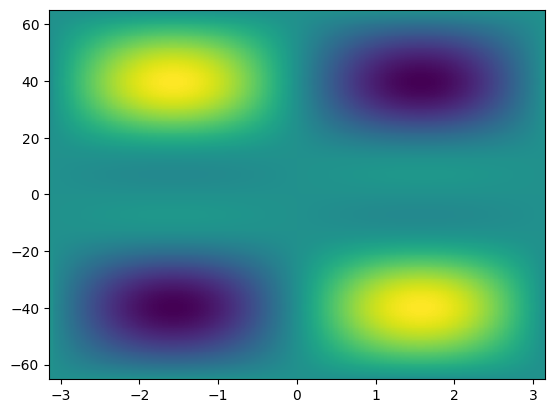

In [49]:
plt.pcolormesh(phi2D, z2D, s_grid)
plt.show()

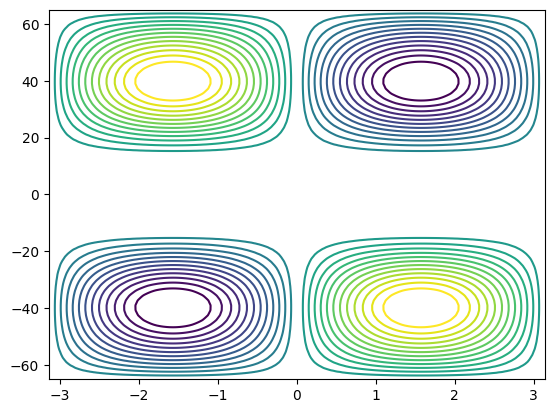

In [50]:
num_wires = 12
levels = np.linspace(np.amin(s_grid), np.amax(s_grid), num_wires*2 + 4)
levels = levels[1:-1]
# Wire should be laid along contours between the isolines, calculate midpoint between isolines
mid_levels = [(levels[i]+levels[i+1])/2 for i in range(np.size(levels)-1)]
mid_levels = np.array(mid_levels)[np.abs(mid_levels) >= 1e-1] #remove zeros, account for floating point error
mid_levels
contours = plt.contour(phi2D,z2D,s_grid,levels = mid_levels)

In [51]:
conjoined = False
wireNum = 0
contourDict = {}
wireLevels = contours.allsegs
direction = 0

if ((direction == 0) and conjoined):        #for the X gradient the center of the smallest contour is needed for joining the wires
    minLength = np.inf
    for wireLevel in wireLevels:
        for wire in wireLevel:
            if(np.size(wire,0) < minLength):
                centerHeight = np.abs(np.mean(wire[:,1]))

for wireLevel in wireLevels:
    for wire in wireLevel:
        wirePath3D = np.stack((np.cos(wire[:,0])*R,np.sin(wire[:,0])*R,wire[:,1]),axis=1)
        if(conjoined):
            gapSize = 4 #gap in which the sections are joined
            gapAngle = gapSize/R      
            centerAngle = np.mean(wire[:,0])
            
            if(direction == 0):
                mask = (np.abs(wire[:,0] - centerAngle) > gapAngle) | (np.abs(wirePath3D[:,2]) < centerHeight)
            else:
                mask = (np.abs(wire[:,0] - centerAngle) > gapAngle) | (wirePath3D[:,2] < 0)
            
            while mask[0]:
                mask = np.roll(mask,1)
                wirePath3D = np.roll(wirePath3D, 1, axis = 0)
    
            contourDict[str(wireNum)] = np.stack((wirePath3D[mask, 0],wirePath3D[mask, 1],wirePath3D[mask, 2]),axis=1)
        else:
            contourDict[str(wireNum)] = wirePath3D
        wireNum += 1

if(not conjoined):
    pass
else:
    
    #############################################
    # Join the wires with a gap in to one array #
    #############################################
    
    numCoilSegments = 4             #Number of quadrants

    joinedContour = {}
    joinedContour[str(0)] = contourDict[str(0)]
    joinedContour[str(1)] = contourDict[str(1)]
    joinedContour[str(2)] = contourDict[str(int(2*wireNum/numCoilSegments))]
    joinedContour[str(3)] = contourDict[str(int(2*wireNum/numCoilSegments)+1)]
    
    for idx in range(1,int(wireNum/numCoilSegments)):
        joinedContour[str(0)] = np.append(joinedContour[str(0)], contourDict[str(2*idx)], axis = 0)
        joinedContour[str(1)] = np.append(joinedContour[str(1)], contourDict[str(2*idx+1)], axis = 0)
        joinedContour[str(2)] = np.append(joinedContour[str(2)], contourDict[str(int(2*wireNum/numCoilSegments) + idx*2 )], axis = 0)
        joinedContour[str(3)] = np.append(joinedContour[str(3)], contourDict[str(int(2*wireNum/numCoilSegments) + idx*2 +1)], axis = 0)
    
    
    ############################################
    # Check for consecutive identical elements #
    ############################################
    tol = 1e-5
    for key in joinedContour:
        delta = joinedContour[key][1:,:] - joinedContour[key][:-1,:]
        delta = np.sum(np.square(delta), axis = 1)
        zeroElements = delta < tol
        joinedContour[key] = np.delete(joinedContour[key],np.nonzero(zeroElements), axis = 0)


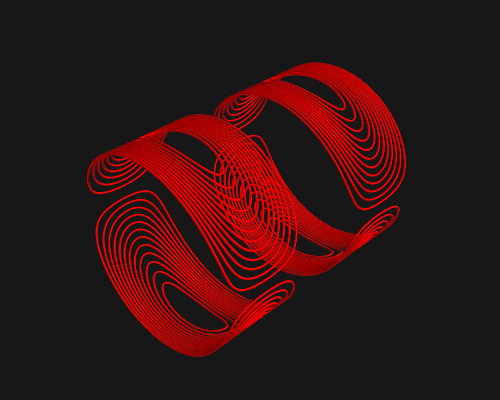

In [52]:
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(.5, .5, .5), size=(500, 400))
for i in range(len(contourDict)):
    contourDict[str(i)] = np.roll(contourDict[str(i)], 1, axis=1)
    mlab.plot3d(*contourDict[str(i)].T, color=(1, 0, 0), tube_radius=0.5)
f

In [55]:
for i in range(len(contourDict)):
    np.savetxt(f"contour_paths/line_{i}.txt", contourDict[str(i)])

In [53]:
conjoined = True
wireNum = 0
contourDict = {}
wireLevels = contours.allsegs
direction = 0

if ((direction == 0) and conjoined):        #for the X gradient the center of the smallest contour is needed for joining the wires
    minLength = np.inf
    for wireLevel in wireLevels:
        for wire in wireLevel:
            if(np.size(wire,0) < minLength):
                centerHeight = np.abs(np.mean(wire[:,1]))

for wireLevel in wireLevels:
    for wire in wireLevel:
        wirePath3D = np.stack((np.cos(wire[:,0])*R,np.sin(wire[:,0])*R,wire[:,1]),axis=1)
        if(conjoined):
            gapSize = 4 #gap in which the sections are joined
            gapAngle = gapSize/R      
            centerAngle = np.mean(wire[:,0])
            
            if(direction == 0):
                mask = (np.abs(wire[:,0] - centerAngle) > gapAngle) | (np.abs(wirePath3D[:,2]) < centerHeight)
            else:
                mask = (np.abs(wire[:,0] - centerAngle) > gapAngle) | (wirePath3D[:,2] < 0)
            
            while mask[0]:
                mask = np.roll(mask,1)
                wirePath3D = np.roll(wirePath3D, 1, axis = 0)
    
            contourDict[str(wireNum)] = np.stack((wirePath3D[mask, 0],wirePath3D[mask, 1],wirePath3D[mask, 2]),axis=1)
        else:
            contourDict[str(wireNum)] = wirePath3D
        wireNum += 1

if(not conjoined):
    pass
else:
    
    #############################################
    # Join the wires with a gap in to one array #
    #############################################
    
    numCoilSegments = 4             #Number of quadrants

    joinedContour = {}
    joinedContour[str(0)] = contourDict[str(0)]
    joinedContour[str(1)] = contourDict[str(1)]
    joinedContour[str(2)] = contourDict[str(int(2*wireNum/numCoilSegments))]
    joinedContour[str(3)] = contourDict[str(int(2*wireNum/numCoilSegments)+1)]
    
    for idx in range(1,int(wireNum/numCoilSegments)):
        joinedContour[str(0)] = np.append(joinedContour[str(0)], contourDict[str(2*idx)], axis = 0)
        joinedContour[str(1)] = np.append(joinedContour[str(1)], contourDict[str(2*idx+1)], axis = 0)
        joinedContour[str(2)] = np.append(joinedContour[str(2)], contourDict[str(int(2*wireNum/numCoilSegments) + idx*2 )], axis = 0)
        joinedContour[str(3)] = np.append(joinedContour[str(3)], contourDict[str(int(2*wireNum/numCoilSegments) + idx*2 +1)], axis = 0)
    
    
    ############################################
    # Check for consecutive identical elements #
    ############################################
    tol = 1e-5
    for key in joinedContour:
        delta = joinedContour[key][1:,:] - joinedContour[key][:-1,:]
        delta = np.sum(np.square(delta), axis = 1)
        zeroElements = delta < tol
        joinedContour[key] = np.delete(joinedContour[key],np.nonzero(zeroElements), axis = 0)


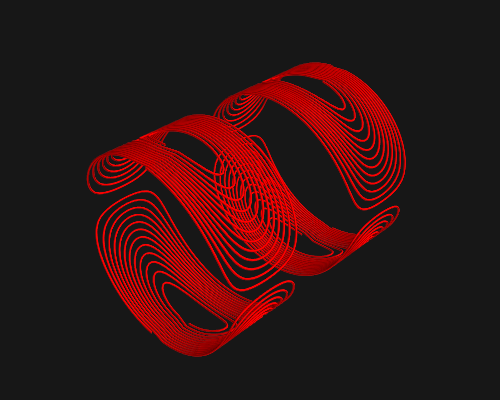

In [54]:
f = mlab.figure(bgcolor=(23./255, 23./255, 23./255), fgcolor=(.5, .5, .5), size=(500, 400))
for i in range(len(joinedContour)):
    joinedContour[str(i)] = np.roll(joinedContour[str(i)], 1, axis=1)
    mlab.plot3d(*joinedContour[str(i)].T, color=(1, 0, 0), tube_radius=0.5)
f

In [56]:
for i in range(len(joinedContour)):
    np.savetxt(f"joined_contour_paths/line_{i}.txt", joinedContour[str(i)])